In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='gpt2'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'wd':[]}

In [4]:
g = 2
lr = 1.0e-4
weight_decay = [0.1, 0.01]

for wd in weight_decay:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}, weight decay {wd}')
    data = ClimateDataset(model_to_train=3,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=wd,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalloss=True,
                                                       gamma=g,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['wd'].append(wd)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search gpt2, learning rate 0.0001, focal loss gamma 2, weight decay 0.1


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	18.6410	Val Loss:	2.2711	Accuracy:	0.0414	F1:	0.0162
2 / 30: Train Loss:	15.0717	Val Loss:	2.2030	Accuracy:	0.0888	F1:	0.0661
3 / 30: Train Loss:	12.3402	Val Loss:	2.1014	Accuracy:	0.2219	F1:	0.2084
4 / 30: Train Loss:	8.3638	Val Loss:	1.6318	Accuracy:	0.3905	F1:	0.4071
5 / 30: Train Loss:	5.3002	Val Loss:	1.3902	Accuracy:	0.5148	F1:	0.4999
6 / 30: Train Loss:	3.3559	Val Loss:	1.3080	Accuracy:	0.5414	F1:	0.5501
7 / 30: Train Loss:	2.7986	Val Loss:	1.3305	Accuracy:	0.5118	F1:	0.5121
8 / 30: Train Loss:	2.1436	Val Loss:	1.2922	Accuracy:	0.5769	F1:	0.5593
9 / 30: Train Loss:	1.3801	Val Loss:	1.1675	Accuracy:	0.5710	F1:	0.5559
10 / 30: Train Loss:	0.6722	Val Loss:	1.2347	Accuracy:	0.6036	F1:	0.5937
11 / 30: Train Loss:	0.5170	Val Loss:	1.2200	Accuracy:	0.6183	F1:	0.6020
12 / 30: Train Loss:	0.3939	Val Loss:	1.1481	Accuracy:	0.6302	F1:	0.5985
13 / 30: Train Loss:	0.3382	Val Loss:	1.3268	Accuracy:	0.5799	F1:	0.5682
14 / 30: Train Loss:	0.3518	Val Loss:	1.1720	Accuracy:	0.

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	18.6424	Val Loss:	2.2672	Accuracy:	0.0444	F1:	0.0200
2 / 30: Train Loss:	15.0786	Val Loss:	2.2204	Accuracy:	0.0976	F1:	0.0785
3 / 30: Train Loss:	12.3792	Val Loss:	2.1734	Accuracy:	0.2071	F1:	0.1922
4 / 30: Train Loss:	8.4249	Val Loss:	1.6273	Accuracy:	0.3787	F1:	0.3875
5 / 30: Train Loss:	5.2403	Val Loss:	1.3914	Accuracy:	0.5296	F1:	0.5106
6 / 30: Train Loss:	3.5419	Val Loss:	1.2719	Accuracy:	0.5562	F1:	0.5613
7 / 30: Train Loss:	2.6162	Val Loss:	1.2665	Accuracy:	0.5473	F1:	0.5557
8 / 30: Train Loss:	1.9451	Val Loss:	1.2038	Accuracy:	0.5503	F1:	0.5422
9 / 30: Train Loss:	1.1125	Val Loss:	1.1228	Accuracy:	0.5651	F1:	0.5754
10 / 30: Train Loss:	0.6627	Val Loss:	1.2073	Accuracy:	0.5680	F1:	0.5603
11 / 30: Train Loss:	0.5439	Val Loss:	1.2016	Accuracy:	0.6124	F1:	0.5882
12 / 30: Train Loss:	0.4152	Val Loss:	1.1225	Accuracy:	0.6420	F1:	0.6373
13 / 30: Train Loss:	0.2227	Val Loss:	1.3693	Accuracy:	0.5473	F1:	0.5380
14 / 30: Train Loss:	0.1722	Val Loss:	1.1478	Accuracy:	0.

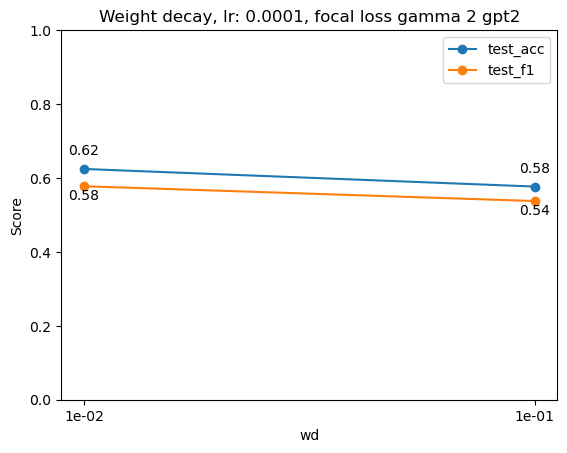

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Weight decay, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='wd',
                        sci_format=True)

In [6]:
%reset -f